# 2차시
## 영화리뷰 감성분석 모델 만들기 (With Logistic Regression)

In [34]:
import urllib
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tqdm import tqdm
tqdm.pandas()

### 데이터 불러오기

In [35]:
# URL로부터 데이터 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
                            filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
                            filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x321d10cd0>)

In [36]:
# pandas로 txt 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

### 데이터 전처리

In [37]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [38]:
train_data["label"].unique()
# 0이 부정, 1이 긍정

array([0, 1])

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [40]:
# 정규 표현식 사용해 document를 한글과 공백만 남김
def clean_str(text):
    text = str(text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)

    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", text) # 한글만 포함

    # 공백이면 nan 치환
    if re.match(r'^\s*$', str(text)):
        return np.nan

    return text

train_data['document'] = train_data['document'].apply(clean_str)

In [41]:
train_data['document'].sample(5)

143166    남자주인공의 연기아쉽지만 못 봐줄정도는 아니라서 재밌게봤음 영상도 예쁘고 내용도 좋고
129910                       광주 감성팔이로 돈이나 읃어먹으려고 하는거 한심하다
50680                                 레지던트 이블  끝나지 않냐  전쟁
81105                                                  재미
48205                                          카핑 베토벤 아류작
Name: document, dtype: object

In [42]:
# Null 제거
print(np.sum(train_data.isna()))
train_data = train_data.dropna()
train_data.info()

id             0
document    1615
label          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 148385 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        148385 non-null  int64 
 1   document  148385 non-null  object
 2   label     148385 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


/Users/mun-wonchan/opt/anaconda3/envs/recsys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


label
0    74397
1    73988
dtype: int64


<Axes: xlabel='label'>

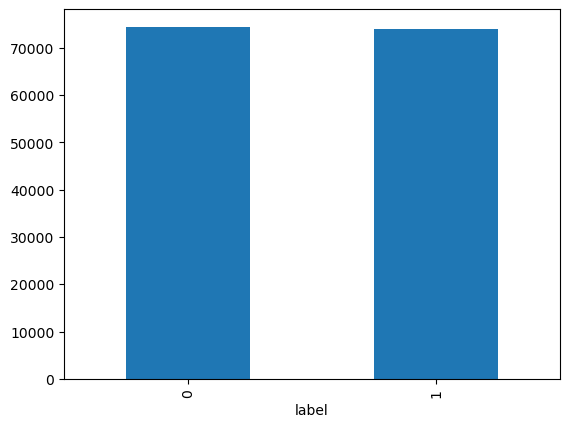

In [43]:
# 0, 1 비율 체크
print(train_data.groupby('label').size())
train_data['label'].value_counts().plot(kind = 'bar')

In [44]:
# 불용어 제거
from konlpy.tag import Okt

def remove_stopwords(text):
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    okt = Okt()
    tokens = okt.morphs(str(text))  # 형태소 분석
    tokens = [word for word in tokens if word not in stopwords]  # 불용어 제거
    return ' '.join(tokens)

# train_data['cleaned_document'] = train_data['document'].apply(remove_stopwords)
train_data['cleaned_document'] = train_data['document'].progress_apply(remove_stopwords)

100%|██████████| 148385/148385 [04:14<00:00, 583.42it/s]


In [45]:
train_data.sample(5)

,id,document,label,cleaned_document
108551,7745788,걍 멍함코미디,0,멍함 코미디
101232,8554558,진짜 리암리슨 믿고 봤는데 보면서 멘붕한영화 기억을 잃었으니까 내가 죽일려 했던 놈...,0,진짜 리암 리슨 믿고 봤는데 보면서 멘붕 영화 기억 을 잃었으니까 내 죽일려 했던 ...
145888,6727198,마음을 건드리게 하는 그리고 생각하지 못한 스토리에 대한 마무리도 좋았던,1,마음 을 건드리게 하는 그리고 생각 하지 못 스토리 대한 마무리 좋았던
113211,9559022,고맙습니다 이런 명작을 성인이 되서 다시 보게 되니 정말 감회가 새롭네요 저도 모...,1,고맙습니다 이런 명작 을 성인 되서 다시 보게 되니 정말 감회 새롭네요 저 모르게 ...
146583,2889962,년대 느와르액션을 아직도 고집하는 홍콩영화오버액션의 진수다,0,년대 느와르 액션 을 아직도 고집 하는 홍콩영화 오버액션 진수 다


In [46]:
# 벡터화
tf_vectorizer = CountVectorizer()
tf_train_features = tf_vectorizer.fit_transform(train_data["cleaned_document"])

### 로지스틱 회귀 학습

In [47]:
lr_tf = LogisticRegression(max_iter=1000)
lr_tf.fit(tf_train_features, train_data["label"])

LogisticRegression(max_iter=1000)

In [48]:
# 학습 잘 됐는지 확인
pred_labels = lr_tf.predict(tf_train_features)
print('Misclassified samples: {} out of {}'.format((pred_labels != train_data["label"]).sum(),len(train_data["label"])))
print('Accuracy: %.2f' % accuracy_score(train_data["label"], pred_labels))

Misclassified samples: 12897 out of 148385
Accuracy: 0.91


In [49]:
# vocablist = tf_vectorizer.vocabulary_

In [50]:
# 계수 확인
# coefficients = lr_tf.coef_.tolist()

# # coefficient값이 큰 순으로 정렬 'reverse=True'
# sorted_coefficients = sorted(enumerate(coefficients[0]), key=lambda x:x[1], reverse=True)

# # 긍정 단어 상위 20개
# for word, coef in sorted_coefficients[:20]:
#     print('{0:} ({1:.3f})'.format(vocablist[word], coef))

# # 부정 단어 상위 20개
# for word, coef in sorted_coefficients[-20:]:
#     print('{0:} ({1:.3f})'.format(vocablist[word], coef))

### 로지스틱 회귀 테스트

In [51]:
# 정규 표현식 적용
test_data['document'] = test_data['document'].apply(clean_str)

In [52]:
# Null 제거
print(np.sum(test_data.isna()))
test_data = test_data.dropna()
test_data.info()

id            0
document    570
label         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 49430 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49430 non-null  int64 
 1   document  49430 non-null  object
 2   label     49430 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


/Users/mun-wonchan/opt/anaconda3/envs/recsys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [53]:
# 불요어 제거 및 벡터화
test_data['cleaned_document'] = test_data['document'].progress_apply(remove_stopwords)
tf_test_features = tf_vectorizer.transform(test_data['cleaned_document'])

100%|██████████| 49430/49430 [01:15<00:00, 652.37it/s] 


In [54]:
# 테스트
pred_labels_test = lr_tf.predict(tf_test_features)
print('Misclassified samples: {} out of {}'.format((pred_labels_test != test_data["label"]).sum(),len(test_data["label"])))
print('Accuracy: %.2f' % accuracy_score(test_data["label"], pred_labels_test))

Misclassified samples: 8073 out of 49430
Accuracy: 0.84


### 오분류 분석

In [55]:
misclassified = test_data[pred_labels_test != test_data["label"]]

In [56]:
misclassified.sample(10)

,id,document,label,cleaned_document
23495,7942638,이건 진짜 돼에에에에봑,1,이건 진짜 돼에에에에봑
32545,2599010,시궁창 냄새 가득한 기득권 권력유지의 작태,1,시궁창 냄새 가득한 기득권 권력 유지 작태
39295,9428050,안봐도 뻔하다 점 주고싶다,0,안 봐도 뻔하다 점 주고싶다
34041,5084469,헐 케로로 극장판중 제일 재밌없다,0,헐 케로로 극장판 중 제일 재밌 없다
7136,5323147,너무재밌는영화 꼭보세요,0,너무 재밌는 영화 꼭 보세요
3945,9814351,케이트 윈슬렛 몸 잘봤다,0,케이트 윈슬렛 몸 봤다
15926,3080376,재밋닼,1,재밋닼
35,1018831,은 못나올것 같다,0,못 나올것 같다
29348,3899978,와이어트 어프보다 모든 면에서 낫다는게 중평 감독의 연출력 입증,1,이어트 어프 보다 모든 면 에서 낫다는게 중평 감독 연출 력 입증
40330,9283030,지금 보면 좀 억지 신파극 같은 스토리 주인공들이 너무 바보 멍청이 같음 상황판단만...,0,지금 보면 억지 신파극 같은 스토리 주인공 너무 바보 멍청이 같음 상황 판단 만 했...


### 리뷰 예측해보기

In [57]:
def sentiment_predict(text):
    text = clean_str(text)
    text =  remove_stopwords(text)
    print(text)
    sample = []
    sample.append(text)
    tf_features = tf_vectorizer.transform(sample)
    score = float(lr_tf.predict_proba(tf_features)[:, 1]) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [58]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

영화 개꿀잼
87.94% 확률로 긍정 리뷰입니다.



In [59]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

영화 핵 노잼
95.43% 확률로 부정 리뷰입니다.



### 데드풀과 울버린 리뷰들에 적용

In [60]:
sentiment_predict('반가운 히어로들도 많이 나와서 좋긴했는데 솔직히 조금 지루했다')

반가운 히어로 많이 나와서 좋긴 했는데 솔직히 조금 지루했다
86.12% 확률로 부정 리뷰입니다.



In [61]:
sentiment_predict('이게 그동안 우리가 기대했던 멀티버스')

게 그동안 우리 기대했던 멀티버스
72.33% 확률로 긍정 리뷰입니다.



In [62]:
sentiment_predict('이게 마블의 신이라고? 너무 기대해서 그런가 그냥 무난한 b급 영화던데.. 그리고 영화가 진입장벽이 너무 높음.. 100프로 이해하기 힘든 영화')

게 마블 신 이라고 너무 기대해서 그 런가 그냥 무난 급 영화 던데 그리고 영화 진입 장벽 너무 높음 프로 이해 하기 힘든 영화
99.64% 확률로 부정 리뷰입니다.



In [63]:
sentiment_predict('아이디어 하나만으로 스릴러를 만들면 이렇게 된다.')

아이디어 하나 만으로 스릴러 만들면 이렇게 된다
77.56% 확률로 부정 리뷰입니다.



### joblib으로 모델 저장 및 불러오기

In [64]:
import joblib
# 모델 저장
joblib.dump(lr_tf, 'lr_movie_ratings.pkl')

# 모델 불러오기
loaded_model = joblib.load('lr_movie_ratings.pkl')

In [67]:
def sentiment_predict_loaded_model(text):
    text = clean_str(text)
    text =  remove_stopwords(text)
    print(text)
    sample = []
    sample.append(text)
    tf_features = tf_vectorizer.transform(sample)
    score = float(loaded_model.predict_proba(tf_features)[:, 1]) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [69]:
sentiment_predict_loaded_model('반가운 히어로들도 많이 나와서 좋긴했는데 솔직히 조금 지루했다')

반가운 히어로 많이 나와서 좋긴 했는데 솔직히 조금 지루했다
86.12% 확률로 부정 리뷰입니다.



In [66]:
import os; os.system('afplay /System/Library/Sounds/Submarine.aiff')

0

# 참고 자료
### [네이버 영화 리뷰 감성 분류하기](https://wikidocs.net/44249)
### [영화리뷰 감성분석 (Sentiment Analysis)](https://yeong-jin-data-blog.tistory.com/entry/%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0-%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D-Sentiment-Analysis)
### [아나콘다 환경에서 konlpy 사용시 jvm.dll 못찾는 오류](https://rural-mouse.tistory.com/5)
### [Tensorflow LSTM 모델 (public score : 0.848)](https://dacon.io/competitions/official/235864/codeshare/4160)